[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eladrich/pixel2style2pixel/blob/master/notebooks/inference_playground.ipynb)

In [1]:
import os
os.chdir('/content')
CODE_DIR = 'stylegansuperresolution'

In [3]:
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force 

In [4]:
os.chdir(f'./{CODE_DIR}')

In [5]:
from argparse import Namespace
import time
import sys
import pprint
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

sys.path.append(".")
sys.path.append("..")

from datasets import augmentations
from utils.common import tensor2im, log_input_image
from models.psp import pSp

%load_ext autoreload
%autoreload 2

## Step 1: Select Experiment Type

In [ ]:
experiment_type = 'celebs_super_resolution' #@param ['ffhq_encode', 'ffhq_frontalize', 'celebs_sketch_to_face', 'celebs_seg_to_face', 'celebs_super_resolution', 'toonify']

## Step 2: Download Pretrained Models 
As part of this repository, we provide pretrained models for each of the above experiments. We'll download the model for the selected experiments as save it to the folder `../pretrained_models`.

In [7]:
def get_download_model_command(file_id, file_name):
    """ Get wget download command for downloading the desired model and save to directory ../pretrained_models. """
    current_directory = os.getcwd()
    save_path = os.path.join(os.path.dirname(current_directory), CODE_DIR, "pretrained_models")
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    url = r"""wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={FILE_ID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={FILE_ID}" -O {SAVE_PATH}/{FILE_NAME} && rm -rf /tmp/cookies.txt""".format(FILE_ID=file_id, FILE_NAME=file_name, SAVE_PATH=save_path)
    return url

In [8]:
MODEL_PATHS = {
    "celebs_sketch_to_face": {"id": "1lB7wk7MwtdxL-LL4Z_T76DuCfk00aSXA", "name": "psp_celebs_sketch_to_face.pt"},
    "celebs_seg_to_face": {"id": "1VpEKc6E6yG3xhYuZ0cq8D2_1CbT0Dstz", "name": "psp_celebs_seg_to_face.pt"},
    "celebs_super_resolution": {"id": "1ZpmSXBpJ9pFEov6-jjQstAlfYbkebECu", "name": "psp_celebs_super_resolution.pt"},
    "toonify": {"id": "1YKoiVuFaqdvzDP5CZaqa3k5phL-VDmyz", "name": "psp_ffhq_toonify.pt"}
}

path = MODEL_PATHS[experiment_type]
download_command = get_download_model_command(file_id=path["id"], file_name=path["name"])

In [11]:
!{download_command}

## Step 3: Define Inference Parameters

Below we have a dictionary defining parameters such as the path to the pretrained model to use and the path to the image to perform inference on.  
While we provide default values to run this script, feel free to change as needed.

In [12]:
EXPERIMENT_DATA_ARGS = {
    "ffhq_encode": {
        "model_path": "pretrained_models/psp_ffhq_encode.pt",
        "image_path": "notebooks/test\ data/Set5/baby.png",
        "transform": transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    },
    "ffhq_frontalize": {
        "model_path": "pretrained_models/psp_ffhq_frontalization.pt",
        "image_path": "notebooks/test\ data/Set5/baby.png",
        "transform": transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    },
    "celebs_sketch_to_face": {
        "model_path": "pretrained_models/psp_celebs_sketch_to_face.pt",
        "image_path": "notebooks/test\ data/Set5/baby.png",
        "transform": transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()])
    },
    "celebs_seg_to_face": {
        "model_path": "pretrained_models/psp_celebs_seg_to_face.pt",
        "image_path": "notebooks/test\ data/Set5/baby.png",
        "transform": transforms.Compose([
            transforms.Resize((256, 256)),
            augmentations.ToOneHot(n_classes=19),
            transforms.ToTensor()])
    },
    "celebs_super_resolution": {
        "model_path": "pretrained_models/psp_celebs_super_resolution.pt",
        "image_path": "notebooks/test\ data/Set5/baby.png",
        "transform": transforms.Compose([
            transforms.Resize((256, 256)),
            augmentations.BilinearResize(factors=[16]),
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    },
    "toonify": {
        "model_path": "pretrained_models/psp_ffhq_toonify.pt",
        "image_path": "notebooks/test\ data/Set5/baby.png",
        "transform": transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    },
}

In [13]:
EXPERIMENT_ARGS = EXPERIMENT_DATA_ARGS[experiment_type]

We need to verify that the model was downloaded correctly. All of our models should weigh approximately 1.12GB.  
Note that if the file weighs several KBs, you most likely encounter a "quota exceeded" error from Google Drive. In that case, you should try downloading the model again after a few hours.

In [14]:
if os.path.getsize(EXPERIMENT_ARGS['model_path']) < 1000000:
  raise ValueError("Pretrained model was unable to be downlaoded correctly!")

## Step 4: Load Pretrained Model
We assume that you have downloaded all relevant models and placed them in the directory defined by the above dictionary.

In [15]:
model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cpu')

In [16]:
opts = ckpt['opts']
pprint.pprint(opts)

{'batch_size': 8,
 'board_interval': 50,
 'checkpoint_path': None,
 'dataset_type': 'celebs_seg_to_face',
 'device': 'cuda:0',
 'encoder_type': 'GradualStyleEncoder',
 'exp_dir': '',
 'id_lambda': 0.0,
 'image_interval': 100,
 'input_nc': 19,
 'l2_lambda': 1.0,
 'l2_lambda_crop': 0,
 'label_nc': 19,
 'learn_in_w': False,
 'learning_rate': 0.0001,
 'lpips_lambda': 0.8,
 'lpips_lambda_crop': 0,
 'max_steps': 80000,
 'optim_name': 'ranger',
 'resize_factors': None,
 'save_interval': 10000,
 'start_from_latent_avg': True,
 'stylegan_weights': '',
 'test_batch_size': 8,
 'test_workers': 8,
 'train_decoder': False,
 'val_interval': 5000,
 'w_norm_lambda': 0.005,
 'workers': 8}


In [17]:
# update the training options
opts['checkpoint_path'] = model_path
if 'learn_in_w' not in opts:
    opts['learn_in_w'] = False
if 'output_size' not in opts:
    opts['output_size'] = 1024

In [18]:
opts = Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

Loading pSp from checkpoint: pretrained_models/psp_celebs_seg_to_face.pt
Model successfully loaded!


## Step 5: Visualize Input

In [19]:
image_path = EXPERIMENT_DATA_ARGS[experiment_type]["image_path"]
original_image = Image.open(image_path)
if opts.label_nc == 0:
    original_image = original_image.convert("RGB")
else:
    original_image = original_image.convert("L")

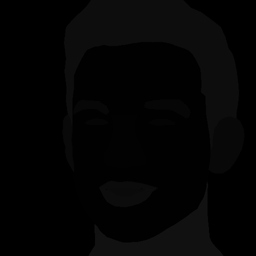

In [20]:
original_image.resize((256, 256))

### Align Image

Note: in this notebook we'll run alignment on the input image for all tasks except for `celebs_sketch_to_face` and `celebs_seg_to_face`. That is, only for tasks with real images as inputs.
However, all of our applications assume the input has been pre-aligned!

In [32]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

In [22]:
def run_alignment(image_path):
  import dlib
  from scripts.align_all_parallel import align_face
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
  aligned_image = align_face(filepath=image_path, predictor=predictor)
  print("Aligned image has shape: {}".format(aligned_image.size))
  return aligned_image

In [23]:
if experiment_type not in ["celebs_sketch_to_face", "celebs_seg_to_face"]:
  input_image = run_alignment(image_path)
else:
  input_image = original_image

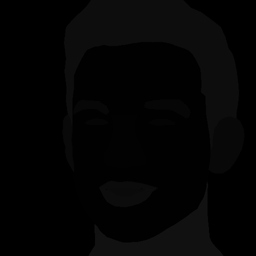

In [24]:
input_image.resize((256, 256))

## Step 6: Perform Inference

In [25]:
img_transforms = EXPERIMENT_ARGS['transform']
transformed_image = img_transforms(input_image)

In [26]:
def run_on_batch(inputs, net, latent_mask=None):
    if latent_mask is None:
        result_batch = net(inputs.to("cuda").float(), randomize_noise=False)
    else:
        result_batch = []
        for image_idx, input_image in enumerate(inputs):
            # get latent vector to inject into our input image
            vec_to_inject = np.random.randn(1, 512).astype('float32')
            _, latent_to_inject = net(torch.from_numpy(vec_to_inject).to("cuda"),
                                      input_code=True,
                                      return_latents=True)
            # get output image with injected style vector
            res = net(input_image.unsqueeze(0).to("cuda").float(),
                      latent_mask=latent_mask,
                      inject_latent=latent_to_inject)
            result_batch.append(res)
        result_batch = torch.cat(result_batch, dim=0)
    return result_batch

Optionally add a latent mask for inference.   
This is typically done only for conditional image synthesis (i.e. face from sketch and face from segmentation map). To disable the use of the latent mask, set `latent_mask = None` in the cell below.  

Feel free to change the cell below to see how the `latent_mask` affects the output image.

In [27]:
if experiment_type in ["celebs_sketch_to_face", "celebs_seg_to_face"]:
    latent_mask = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
else:
    latent_mask = None

In [28]:
with torch.no_grad():
    tic = time.time()
    result_image = run_on_batch(transformed_image.unsqueeze(0), net, latent_mask)[0]
    toc = time.time()
    print('Inference took {:.4f} seconds.'.format(toc - tic))

Inference took 0.4166 seconds.


### Visualize Result

In [29]:
input_vis_image = log_input_image(transformed_image, opts)
output_image = tensor2im(result_image)

In [30]:
if experiment_type == "celebs_super_resolution":
    res = np.concatenate([np.array(input_image.resize((256, 256))),
                          np.array(input_vis_image.resize((256, 256))),
                          np.array(output_image.resize((256, 256)))], axis=1)
else:
    res = np.concatenate([np.array(input_vis_image.resize((256, 256))),
                          np.array(output_image.resize((256, 256)))], axis=1)

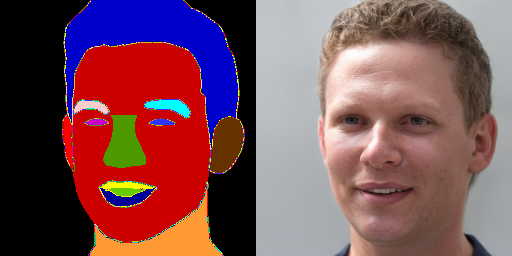

In [33]:
res_image = Image.fromarray(res)
res_image

# Multi-Modal Synthesis

For ambiguous tasks such as conditional image synthesis, where as a single input may have many plausible outputs, it is desirable to generate these possible outputs. To do this with the pSp framework, we perform style mixing with multiple randomly sampled $w$ latents.

We demonstrate this idea below.

There are several relevant parameters for multi-modal synthesis: 
- `latent_mask`: on which layers to perform the style mixing with the randomly drawn sample.
- `mix_alpha`: alpha coefficient to use for mixing between the two styles in each layer.
- `n_outputs_to_generate`: number of outputs to generate per input image

In the paper, we use the following settings: 
- Conditional Image Synthesis (celebs_sketch_to_face and celebs_seg_to_face): 
    - `latent_mask = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17]`
    - `mix_alpha = None`
- Super Resolution
    - `latent_mask = [4, 5, 6, 7]`
    - `mix_alpha = 0.5`
    
Feel free to play with the parameters below to see the effect of each.

In [34]:
if experiment_type in ["celebs_sketch_to_face", "celebs_seg_to_face"]:
    latent_mask = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
    mix_alpha = None
elif experiment_type == "celebs_super_resolution":
    latent_mask = [4, 5, 6, 7]
    mix_alpha = 0.5
else:
    raise ValueError("Multi-modal synthesis is performed only for seg-to-face, sketch-to-face, and super-resolution!")

n_outputs_to_generate = 5

### Generate Outputs

In [50]:
def get_multi_modal_outputs(input_image, vectors_to_inject):
    results = []
    with torch.no_grad():
      for vec_to_inject in vectors_to_inject:
          cur_vec = torch.from_numpy(vec_to_inject).unsqueeze(0).to("cuda")
          # get latent vector to inject into our input image
          _, latent_to_inject = net(cur_vec,
                                    input_code=True,
                                    return_latents=True)
          # get output image with injected style vector
          res = net(input_image.unsqueeze(0).to("cuda").float(),
                    latent_mask=latent_mask,
                    inject_latent=latent_to_inject,
                    alpha=mix_alpha)
          results.append(res[0])
    return results

In [51]:
# randomly draw the latents to use for style mixing
vectors_to_inject = np.random.randn(n_outputs_to_generate, 512).astype('float32')

In [52]:
multi_results = get_multi_modal_outputs(transformed_image, vectors_to_inject)

### Visualize Results

In [53]:
input_vis_image = log_input_image(transformed_image, opts)
res = np.array(input_vis_image.resize((256, 256)))

for output in multi_results:
    output = tensor2im(output)
    res = np.concatenate([res, np.array(output.resize((256, 256)))], axis=1)

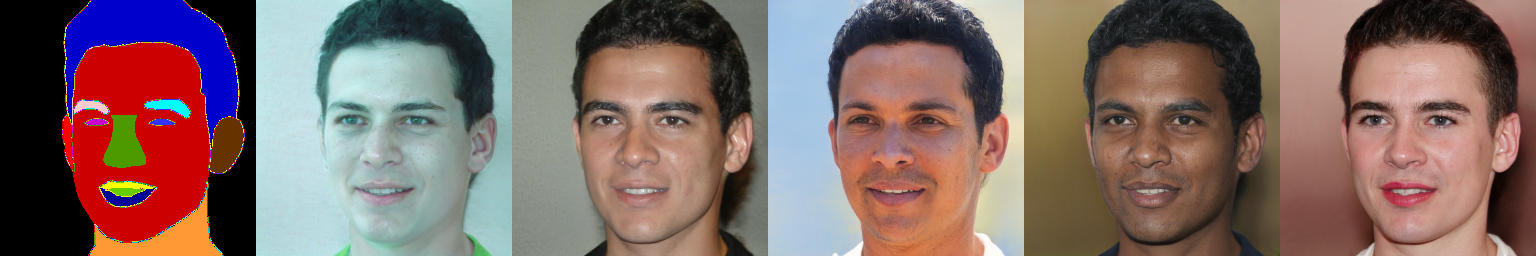

In [54]:
res_image = Image.fromarray(res)
res_image

# Inversion "In the Wild"

As a final example, we'll run our StyleGAN inversion model on images of various images collected from the internet. On each image, we have previously run alignment and resizing to $256\times256$.  
First, we'll reload the `ffhq_encode` pretrained pSp model (in case you've previously loaded a different model). We'll then get and save the extracted images in the directory `./inversion_images`.

In [57]:
experiment_type = 'ffhq_encode'
EXPERIMENT_ARGS = EXPERIMENT_DATA_ARGS[experiment_type]

path = MODEL_PATHS[experiment_type]
download_command = get_download_model_command(file_id=path["id"], file_name=path["name"])
!{download_command}

In [56]:
model_path = EXPERIMENT_ARGS['model_path']

if os.path.getsize(model_path) < 1000000:
  raise ValueError("Pretrained model was unable to be downlaoded correctly!")

ckpt = torch.load(model_path, map_location='cpu')
opts = ckpt['opts']

# update the training options
opts['checkpoint_path'] = model_path
if 'learn_in_w' not in opts:
    opts['learn_in_w'] = False
if 'output_size' not in opts:
    opts['output_size'] = 1024

opts = Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

Loading pSp from checkpoint: pretrained_models/psp_ffhq_encode.pt
Model successfully loaded!


### Extract and Save the Images

In [58]:
def get_download_images_command(file_id, file_name):
    """ Get wget download command for downloading the inversion images and save to directory ./inversion_images. """
    save_path = os.getcwd()
    url = r"""wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={FILE_ID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={FILE_ID}" -O {SAVE_PATH}/{FILE_NAME} && rm -rf /tmp/cookies.txt""".format(FILE_ID=file_id, FILE_NAME=file_name, SAVE_PATH=save_path)
    return url

In [59]:
inversion_images_id = "1wfCiWuHjsj3oGDeYF9Lrkp8vwhTvleBu"
inversion_images_file_name = "inversion_images.zip"
save_path = "./inversion_images"
download_command = get_download_images_command(inversion_images_id, inversion_images_file_name)

In [61]:
!{download_command}
!mkdir {save_path}
!unzip {inversion_images_file_name}

### Visualize the Images

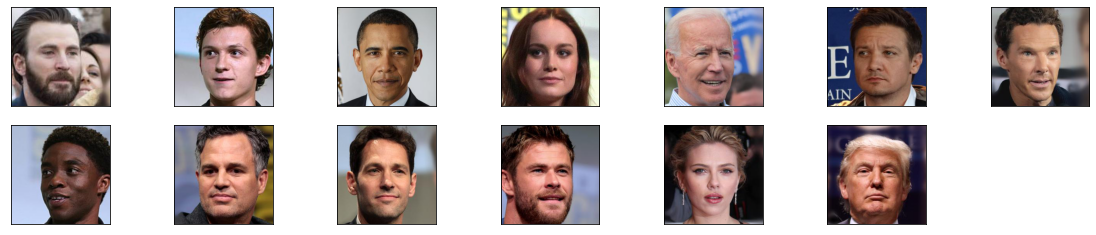

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline

image_paths = [os.path.join(save_path, f) for f in os.listdir(save_path) if f.endswith(".jpg")]
n_images = len(image_paths)

images = []
n_cols = np.ceil(n_images / 2)
fig = plt.figure(figsize=(20, 4))
for idx, image_path in enumerate(image_paths):
    ax = fig.add_subplot(2, n_cols, idx + 1)
    img = Image.open(image_path).convert("RGB")
    images.append(img)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img)
plt.show()

### Run Inference

In [63]:
img_transforms = EXPERIMENT_ARGS['transform']
transformed_images = [img_transforms(image) for image in images]

In [64]:
batched_images = torch.stack(transformed_images, dim=0)

In [65]:
with torch.no_grad():
    tic = time.time()
    result_images = run_on_batch(batched_images, net, latent_mask=None)
    toc = time.time()
    print('Inference took {:.4f} seconds.'.format(toc - tic))

Inference took 1.2290 seconds.


### Visualize Results

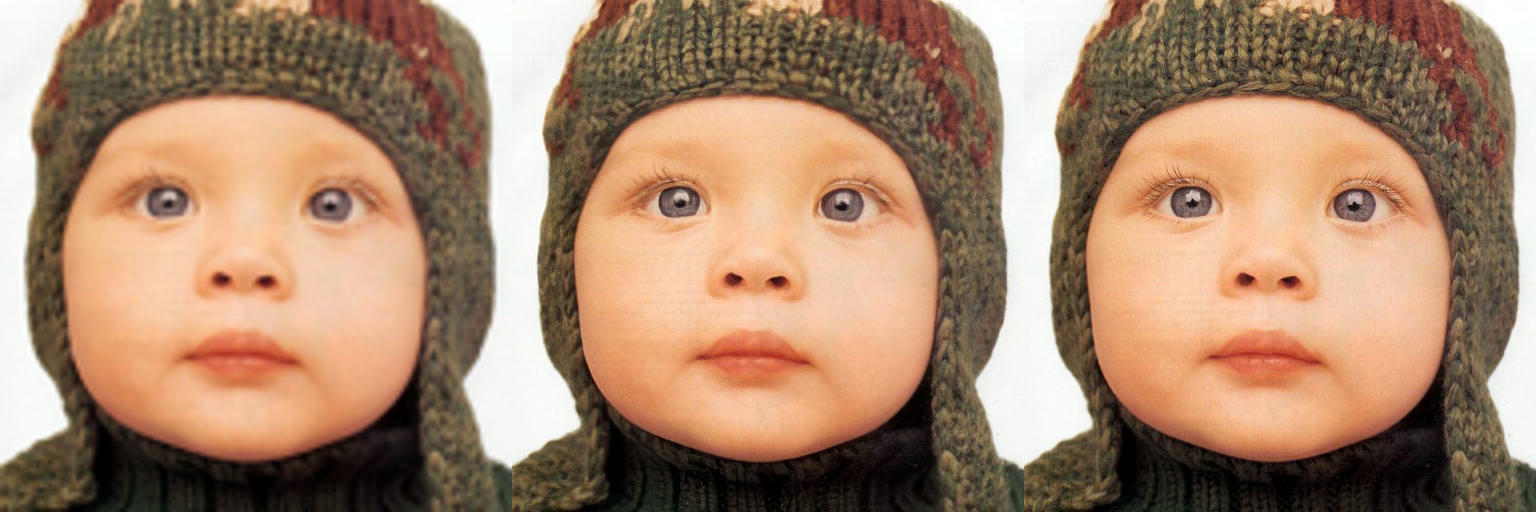

In [2]:
from IPython.display import display

couple_results = []
for original_image, result_image in zip(images, result_images):
    result_image = tensor2im(result_image)
    res = np.concatenate([np.array(original_image.resize((256, 256))),
                          np.array(result_image.resize((256, 256)))], axis=1)
    res_im = Image.fromarray(res)
    couple_results.append(res_im)
    display(res_im)